In [1]:
#import time
#time.sleep(5*3600)

# Workflow for processing Lake George Multi Timeline - 26MAR18

In [39]:
import numpy as np
import sys
sys.path.append("..")

import time
start_time = time.time()

#
# Set up input and output directories
#
indir = '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/Lake_George/26MAR18/'
output = '/g/data/u46/users/aw3463/GuyByrne/calval/PNGS/LKG-MultiTimeLine/'

#
# field_data is in the format: 'Field Site Name', 'Date', 'Site number', 'Satellite Name', 'Panel origin', 'Reflectance/Radiance'.
# and 'Radiance'/'Reflectance'.
# NOTE: Satellite name should be one of: 'Landsat8', 'Sentinel2a', or 'Sentinel2b'.
#
field_data = ['LKG', '26MAR18', '', 'Sentinel2b', 'GA_Panel', 'Radiance']

#
# bad_pans    contains the names of individual panels readings that appear to be bogus
# bad_grounds contains ground-reading file names that appear to be bogus
# Use empty lists if there are no bad spectra.
#
bad_grounds = ['llg_l300010.asd.rad', 'llg_l300011.asd.rad', 'llg_l300038.asd.rad', 'llg_l300039.asd.rad', 'llg_l300040.asd.rad', 'llg_l300041.asd.rad']
#bad_grounds = []
bad_pans = ['lkg_l700000.asd.rad', 'lkg_l700001.asd.rad']
#bad_pans = []

ls8_bad_days = ['2013-06-05', '2013-06-21', '2013-07-07', '2013-08-08', '2013-08-24',
                '2013-09-25', '2013-10-27', '2013-11-12', '2013-11-28', '2013-12-14',
                '2014-02-16', '2014-03-04', '2014-04-05', '2014-05-23', '2014-06-08',
                '2014-06-24', '2014-07-10', '2014-07-26', '2014-08-27', '2014-09-12',
                '2014-11-15', '2014-12-17', '2015-01-02', '2015-01-18', '2015-02-03',
                '2015-02-19', '2015-03-23', '2015-04-08', '2015-04-24', '2015-05-10',
                '2015-05-26', '2015-06-11', '2015-06-27', '2015-07-13', '2015-07-29',
                '2015-08-14', '2015-08-30', '2015-10-17', '2015-11-02', '2015-11-18',
                '2015-12-20', '2016-01-05', '2016-01-21', '2016-02-06', '2016-03-09', 
                '2016-04-10', '2016-05-12', '2016-05-28', '2016-06-29', '2016-07-31', 
                '2016-08-16', '2016-09-01', '2016-09-17', '2016-10-03', '2016-10-19', 
                '2017-01-07', '2017-01-23', '2017-02-24', '2017-03-12', '2017-04-13', 
                '2017-04-29', '2017-06-16', '2017-07-02', '2017-07-18', '2017-08-03', 
                '2017-09-04', '2017-12-25', '2018-01-10', '2018-01-26', '2018-02-27',
                '2018-03-15', '2018-05-18', '2018-06-03', '2018-06-19', '2018-07-05',
                '2018-07-21', '2018-08-06', '2018-08-22', '2018-09-07']
s2a_bad_days = ['2015-09-03', '2015-10-23', '2015-11-12', '2016-01-31', '2016-05-20',
                '2016-06-09', '2016-06-29', '2016-07-19', '2016-08-08', '2016-08-28',
                '2016-10-07', '2016-10-17', '2016-10-27', '2016-12-06', '2016-12-16',
                '2017-01-05', '2017-02-14', '2017-02-24', '2017-03-06', '2017-03-16',
                '2017-04-05', '2017-04-15', '2017-04-25', '2017-05-05', '2017-05-15',
                '2017-05-25', '2017-06-04', '2017-06-14', '2017-07-24', '2017-08-23',
                '2017-09-22', '2017-10-12', '2017-11-01', '2017-12-01',
                '2017-12-21', '2018-01-10', '2018-01-30', '2018-02-19', '2018-03-21',
                '2018-03-31', '2018-04-10', '2018-05-30', '2018-06-09', '2018-06-19', 
                '2018-06-29', '2018-07-09']
s2b_bad_days = ['2017-07-09', '2017-08-18', '2017-09-07', '2017-10-27',
                '2017-11-06', '2017-11-16', '2017-12-06', '2017-12-26', '2018-01-05',
                '2018-02-04', '2018-02-24', '2018-03-06', '2018-03-16', '2018-04-15',
                '2018-05-15', '2018-05-25', '2018-06-04', '2018-06-14', '2018-06-24']

ls8_csvs = ['LKG_03MAY18__Landsat8.csv', 'LKG_04JUL18__Landsat8.csv', 'LKG_05APR18__Landsat8.csv',
            'LKG_12FEB18_Site1_Landsat8.csv', 'LKG_24JUL18__Landsat8.csv', 'LKG_26MAR18__Landsat8.csv']

sent_csvs = ['LKG_03MAY18__Sentinel2a.csv', 'LKG_04JUL18__Sentinel2b.csv', 'LKG_05APR18__Sentinel2b.csv',
             'LKG_12FEB18_Site1_Sentinel2a.csv', 'LKG_24JUL18__Sentinel2b.csv', 'LKG_26MAR18__Sentinel2b.csv']

rain_dat = '../Weather/IDCJAC0009_070346_1800_Data.csv'

#
# Define the first line and spectrum number for all/good panels and grounds
#
firstGoodLine = 1
firstGoodPanelSpec = 0
firstGoodGroundSpec = 2

#
# Calculated BRDF data
#
brdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 0.08476, 0.023340000000000003, 0.014063333333333334],
                          ['band11', 0.32967666666666673, 0.18692, 0.03803666666666667],
                          ['band12', 0.24544000000000002, 0.08737666666666667, 0.04081333333333333],
                          ['band2', 0.08476, 0.023340000000000003, 0.014063333333333334],
                          ['band3', 0.12583333333333332, 0.04871666666666667, 0.02095666666666667],
                          ['band4', 0.13959000000000002, 0.054163333333333334, 0.022923333333333334],
                          ['band5', 0.13959000000000002, 0.054163333333333334, 0.022923333333333334],
                          ['band6', 0.13959000000000002, 0.054163333333333334, 0.022923333333333334],
                          ['band7', 0.26591, 0.15480000000000002, 0.027993333333333335],
                          ['band8', 0.26591, 0.15480000000000002, 0.027993333333333335],
                          ['band8a', 0.26591, 0.15480000000000002, 0.027993333333333335],
                         ])

#
# plot_scale defines the extent of the axes in the final two plots in the workflow.
# A scale from 0-1 means no reflectance to perfect reflectance. Typically, dark sites
# will range from 0-0.3, whereas bright sites will be between 0-1.
#
plot_scale = [0.0, 1.0, 0.0, 1.0]

#
# Define corners of field data, if GPS coordinates are NOT written into headers.
# Order is SE, SW, NE, NW. Units are decimal degrees.
# If there are no coordinates, then set RockWalk to either True or False.
# True  means that the field site was walked in a rock-like pattern (alternating directions),
# False means that the field site was walked in a roll-like pattern (same direction)
#
Corners = [0, 0, 0, 0, 0, 0, 0, 0]
RockWalk = True
StartCorner = 'SE'

In [3]:
import matplotlib.pyplot as plt
import matplotlib

#
# Astropy is used to determine the Solar angle
#
import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u

import datacube

from CalVal import *

#
# Use notebook format (allows inline zooming and moving of figures)
# Set default font size for all plots
#
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 12})

In [4]:
#######################################
# LINES BELOW SHOULD REMAIN UNCHANGED #
#######################################
#
# panel_dir and in_panel refer to the file that is used in determining the k-factor,
# so this should remain unchanged.
#
if field_data[5] == 'Radiance':
    suffix = 'asd.rad.txt'
else: 
    suffix = 'asd.txt'

panel_dir =  '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/Panels/'

if field_data[4] == 'GA_Panel':
    in_panel = 'ga_panel1_jan_2018.txt'
elif field_data[4] == 'CSIRO_Panel':
    in_panel = 'csiro_panel.txt'
elif field_data[4] == 'UA_Panel':
    in_panel = 'ua_panel.txt'
elif field_data[4] == 'UOW_Panel':
    in_panel = 'uow_panel.txt'
elif field_data[4] == 'UQ_Panel':
    in_panel = 'uq_panel.txt'
elif field_data[4] == 'CSIRO_VIC_Panel':
    in_panel = 'csiro_vic_panel.txt'
else:
    nopanel = '***PANEL NAME NOT KNOWN***'
    print(nopanel)

#
# Setup for Landsat and Sentinel bandpass filters
#
sat_resp = dict({'Landsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'Landsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'Landsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt',
            'Sentinel2a': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2a.flt',
            'Sentinel2b': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2b.flt'})

f_name = sat_resp[field_data[3]]

#
# Colours used for plotting multi-coloured Lines
#
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

#
# Start Figure numbering at 1
#
fignum = 1



### Define 'alldata' as the dataframe that contains all the raw spectra.
Show the first wavelength of every spectrum, so that the data integrity can be checked.

In [5]:
alldata = LoadData.load_from_dir(indir, suffix, firstGoodLine, Corners)

alldata[alldata['Wavelength']==350]

Wavelength  radiance             filename          date_saved   Latitude  \
0          350  0.125462  llg_l100000.asd.rad 2018-03-26 00:12:58 -35.093052   
0          350  0.125446  llg_l100001.asd.rad 2018-03-26 00:13:01 -35.093052   
0          350  0.004827  llg_l100002.asd.rad 2018-03-26 00:13:22 -35.093030   
0          350  0.004636  llg_l100003.asd.rad 2018-03-26 00:13:26 -35.093030   
0          350  0.005039  llg_l100004.asd.rad 2018-03-26 00:13:33 -35.093022   
0          350  0.004800  llg_l100005.asd.rad 2018-03-26 00:13:37 -35.093018   
0          350  0.004970  llg_l100006.asd.rad 2018-03-26 00:13:40 -35.093017   
0          350  0.004882  llg_l100007.asd.rad 2018-03-26 00:13:44 -35.093017   
0          350  0.005296  llg_l100008.asd.rad 2018-03-26 00:14:25 -35.092983   
0          350  0.005047  llg_l100009.asd.rad 2018-03-26 00:14:29 -35.092965   
0          350  0.004592  llg_l100010.asd.rad 2018-03-26 00:14:32 -35.092950   
0          350  0.005170  llg_l100011.asd.rad 2018-03-26 00:14:36 -35.092947   
0          350  0.004740  llg_l100012.asd.rad 2018-03-26 00:14:39 -35.092900   
0          350  0.004719  llg_l100013.asd.rad 2018-03-26 00:14:43 -35.092903   
0          350  0.005059  llg_l100014.asd.rad 2018-03-26 00:14:47 -35.092913   
0          350  0.004930  llg_l100015.asd.rad 2018-03-26 00:14:50 -35.092925   
0          350  0.005071  llg_l100016.asd.rad 2018-03-26 00:14:54 -35.092940   
0          350  0.005091  llg_l100017.asd.rad 2018-03-26 00:14:57 -35.092968   
0          350  0.004576  llg_l100018.asd.rad 2018-03-26 00:15:01 -35.092975   
0          350  0.004431  llg_l100019.asd.rad 2018-03-26 00:15:05 -35.092955   
0          350  0.005022  llg_l100020.asd.rad 2018-03-26 00:15:08 -35.092927   
0          350  0.004928  llg_l100021.asd.rad 2018-03-26 00:15:12 -35.092915   
0          350  0.005519  llg_l100022.asd.rad 2018-03-26 00:15:15 -35.092910   
0          350  0.004979  llg_l100023.asd.rad 2018-03-26 00:15:19 -35.092897   
0          350  0.004737  llg_l100024.asd.rad 2018-03-26 00:15:23 -35.092905   
0          350  0.004445  llg_l100025.asd.rad 2018-03-26 00:15:26 -35.092930   
0          350  0.004335  llg_l100026.asd.rad 2018-03-26 00:15:30 -35.092937   
0          350  0.004718  llg_l100027.asd.rad 2018-03-26 00:15:34 -35.092938   
0          350  0.004328  llg_l100028.asd.rad 2018-03-26 00:15:37 -35.092947   
0          350  0.004639  llg_l100029.asd.rad 2018-03-26 00:15:41 -35.092952   
..         ...       ...                  ...                 ...        ...   
0          350  0.004916  lkg_l900010.asd.rad 2018-03-26 00:52:51 -35.092263   
0          350  0.005563  lkg_l900011.asd.rad 2018-03-26 00:52:55 -35.092265   
0          350  0.005306  lkg_l900012.asd.rad 2018-03-26 00:52:58 -35.092267   
0          350  0.005395  lkg_l900013.asd.rad 2018-03-26 00:53:02 -35.092268   
0          350  0.005636  lkg_l900014.asd.rad 2018-03-26 00:53:05 -35.092267   
0          350  0.005490  lkg_l900015.asd.rad 2018-03-26 00:53:09 -35.092268   
0          350  0.004890  lkg_l900016.asd.rad 2018-03-26 00:53:13 -35.092267   
0          350  0.004823  lkg_l900017.asd.rad 2018-03-26 00:53:16 -35.092268   
0          350  0.004996  lkg_l900018.asd.rad 2018-03-26 00:53:20 -35.092267   
0          350  0.005071  lkg_l900019.asd.rad 2018-03-26 00:53:23 -35.092267   
0          350  0.005034  lkg_l900020.asd.rad 2018-03-26 00:53:27 -35.092268   
0          350  0.004805  lkg_l900021.asd.rad 2018-03-26 00:53:31 -35.092272   
0          350  0.005066  lkg_l900022.asd.rad 2018-03-26 00:53:34 -35.092273   
0          350  0.005096  lkg_l900023.asd.rad 2018-03-26 00:53:38 -35.092275   
0          350  0.004400  lkg_l900024.asd.rad 2018-03-26 00:53:42 -35.092277   
0          350  0.004519  lkg_l900025.asd.rad 2018-03-26 00:53:45 -35.092277   
0          350  0.004642  lkg_l900026.asd.rad 2018-03-26 00:53:49 -35.092280   
0          350  0.004800  lkg_l900027.asd.rad 2018-03-26 00:53:52 -35.092283   
0   

### Print out time stamp and coordinate extent for BRDF correction

The time stamp and Lat/Long extents are required to calculate the BRDF correction, used below.

In order to calculate the BRF correction, the following method is used:

<OL>
    <LI>Run the print statements in the cell below.</LI>
    <LI>Copy and paste the output into a VDI terminal window</LI>
    <LI>Copy and paste the resultant VDI output into the BRDF calculation cell, writing over the similar text.</LI>
</OL>

NOTE: This works assuming that the BRDF code is in the current directory.


In [6]:
PrintBRDF.print_brdf(alldata, field_data)

#################################################################################
# Copy and paste the following into a terminal window on VDI for Landsat 8 data #
#################################################################################

source module.sh
sed -i "34s/.*/        setattr(self, 'acquisition_datetime', dateutil.parser.parse('2018-03-26 00:12:58'))/" retrieve_brdf.py
sed -i "37s/.*/        bbox = geopandas.GeoDataFrame({'geometry': [box(149.46134, -35.09305166666667, 149.46277833333335, -35.09225166666667)]})/" retrieve_brdf.py
python retrieve_brdf.py > temp.txt ; awk -f format_Sent.awk temp.txt



### Specify which spectra are panels/ground/good/bad

 Determine panel file names by assuming that all panels have a data value of at least 0.06
 in the first wavelength (350nm). Call this dataframe 'panel_names'.

 good_panels = all panel data with bad panels removed<BR>
 bad_panels  = all bad panel data<BR>
 all_panels = both good and bad panel data<BR>
 good_grounds = good ground readings<BR>
 all_grounds = all ground data.<P>
 Any bad ground data (bad_grounds) is defined in the 2nd cell.


In [7]:
panel_names, all_panels, good_panels, bad_panels, good_grounds, all_grounds = ExtractPanelsGrounds.extract_panels_grounds(alldata, bad_pans, bad_grounds, field_data)

### Create dataframes for all/good/bad panel spectra.

For the bad panel spectra dataframe, first check to see if bad panels have been defined.<BR>
If not, then don't create anything.

In [8]:
all_panel_spec = MakeSpecDF.make_spec_df(all_panels)
good_panel_spec = MakeSpecDF.make_spec_df(good_panels)
try:
    bad_panel_spec = MakeSpecDF.make_spec_df(bad_panels)
except UnboundLocalError:
    pass

# Figure 

### Plot panel radiances for all/good/bad panels

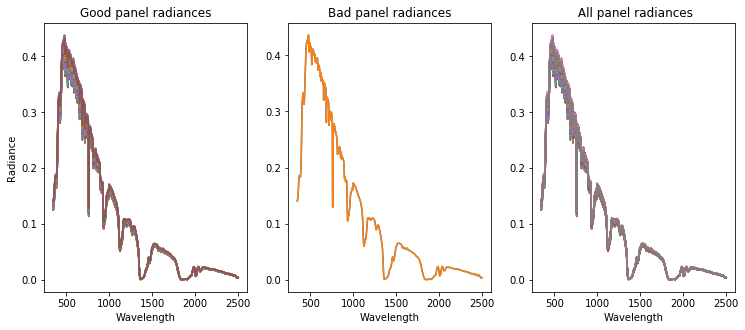

In [9]:
try:
    FIG_PanelRadiances.FIG_panel_radiances(good_panel_spec, bad_panel_spec, all_panel_spec, output, field_data, fignum)
except NameError:
    bad_panel_spec = [0,0]
    FIG_PanelRadiances.FIG_panel_radiances(good_panel_spec, bad_panel_spec, all_panel_spec, output, field_data, fignum)

fignum += 1

# Figure 

### Diagnosis plots of bad panel spectra

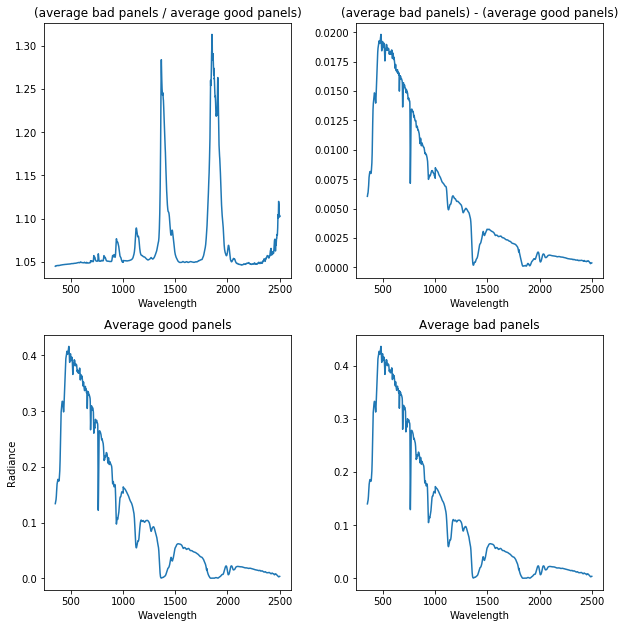

In [10]:
good_panel_mean = good_panel_spec.mean(axis=1)

try:
    FIG_BadPanelAnalysis.FIG_bad_panel_analysis(good_panel_mean, good_panel_spec, bad_panel_spec, output, field_data, fignum)
except AttributeError:
    pass
fignum +=1

### Create spectral dataframes for all ground spectra and good ground spectra

In [11]:
all_grounds_spec = MakeSpecDF.make_spec_df(all_grounds)
good_grounds_spec = MakeSpecDF.make_spec_df(good_grounds)

# Figure 

### Plot ground spectra (all and good), normalised to the median good spectrum

These plots are used to identify any ground spectra that are bogus.

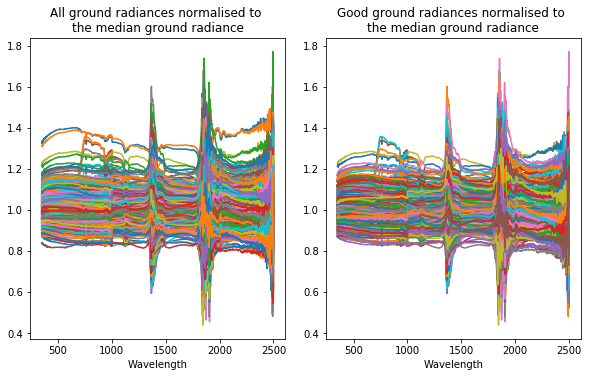

In [12]:
FIG_GroundSpectra.FIG_ground_spectra(good_grounds_spec, all_grounds_spec, output, field_data, fignum)
fignum +=1

### Create time-relative dataframes

gpt = good panels<BR>
gpta = all panels<BR>
adt = good grounds<BR>
adta = all grounds

In [13]:
gpt, gpta, adt, adta = CreateTimeRelativeDF.create_time_relative_dfs(good_panels, all_panels, good_grounds, all_grounds)

# Figure 

### Plot timelines for ALL panel and ground data, with one line in one panel

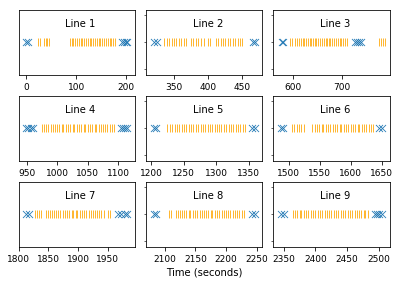

In [14]:
FIG_AllTimelines.FIG_all_timelines(gpta, adta, output, field_data, fignum)
fignum += 1

# Figure 

### Plot timelines for GOOD panel and ground data, with one line in one panel

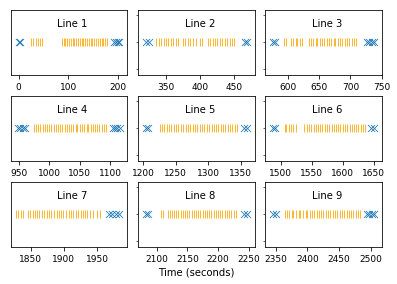

In [15]:
from CalVal.FIG_AllTimelines import panel_plot_layout, multi_timeline_plot

FIG_GoodTimelines.FIG_good_timelines(gpta, gpt, adt, panel_plot_layout, multi_timeline_plot, output, field_data, fignum)
fignum += 1

# Figure 

### Create timeline plot of averaged, normalised all/good panels

These plots are used to identify any panels that show unusually bright or dark readings,<BR>
    which can be weeded out as bad panels.
    
The general shape of the curve should follow "insolation" - the changing of incident light
due to the Sun rising/falling in the sky.

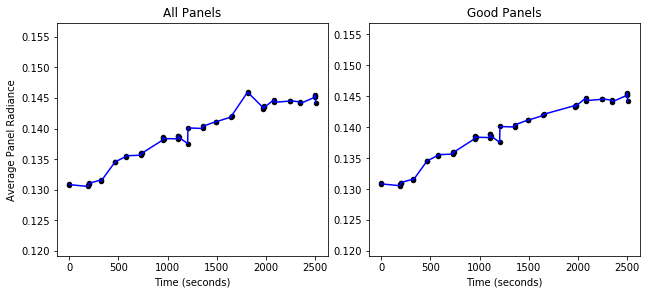

In [16]:
gpt, gpta = FIG_NormalisedPanelsTimeline.normalise_spectra(good_panel_mean, good_panel_spec, all_panel_spec, gpt, gpta)
    
FIG_NormalisedPanelsTimeline.FIG_normalised_panels_timeline(gpt, gpta, output, field_data, fignum)
fignum += 1

### Define the K-factor

This reads a standard file with a response curve for the detector, given an ideally white surface.<BR>
Then "k_f" is defined for the K-factor.

In [17]:
k_f = KFactor.k_factor(panel_dir, in_panel)

### Rename the first spectrum in ALL/GOOD panels to the correct name

Rather than just "radiance", it will be named something like radiance1-0<BR>
for the zeroth spectrum in the first line, for example.    

In [18]:
SpecRename.spec_rename(good_panel_spec, good_grounds_spec, firstGoodLine, firstGoodPanelSpec, firstGoodGroundSpec)

### Create dataframe with Reflectances

In [19]:
all_refls = CreateReflectances.create_reflectances(good_panels, good_panel_spec, good_grounds_spec, k_f)

### Test for reflectances
Test field_data to see if the data were saved as reflectances. If so, bypass all the panelling workflow.

In [20]:
if field_data[5] == 'Reflectance':
    all_refls = good_grounds_spec

# Figure 

### Plot all ground reflectances in black, plus the Line-averaged reflectances in colour

The Line-averaged reflectances are shown in order to identify any outlying lines that<BR>

might have been caused by bad panel spectra (for example).

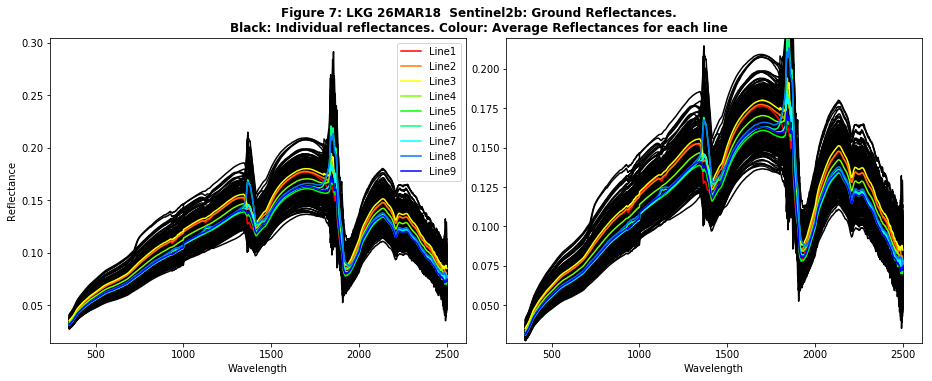

In [21]:
FIG_Reflectances.FIG_reflectances(good_panels, all_refls, colpac, output, field_data, fignum)
fignum += 1

### Apply weighted band responses to all reflectances

In [22]:
f_name = sat_resp['Landsat8']
result_ls8_df, band_ls8 = ApplyWeights.apply_weights(f_name, all_refls)
f_name = sat_resp['Sentinel2a']
result_s2a_df, band_s2a = ApplyWeights.apply_weights(f_name, all_refls)
f_name = sat_resp['Sentinel2b']
result_s2b_df, band_s2b = ApplyWeights.apply_weights(f_name, all_refls)

### Reformat band reflectances and apply to dataframe "ground_bands"

In [23]:
ground_bands_ls8 = ReformatDF.reformat_df(good_grounds, result_ls8_df)
ground_bands_s2a = ReformatDF.reformat_df(good_grounds, result_s2a_df)
ground_bands_s2b = ReformatDF.reformat_df(good_grounds, result_s2b_df)

# Figure 

### Plot band reflectances

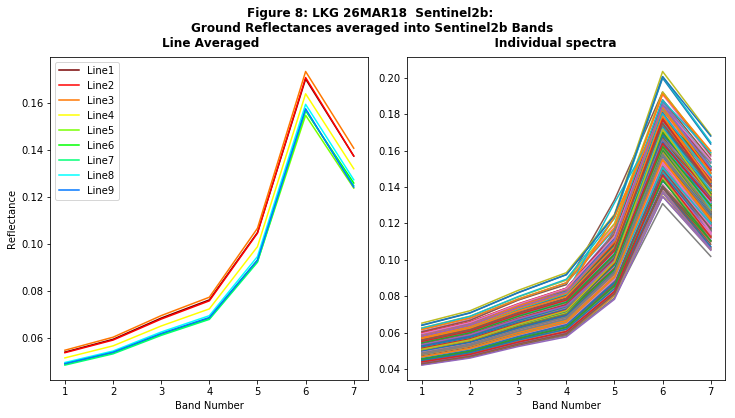

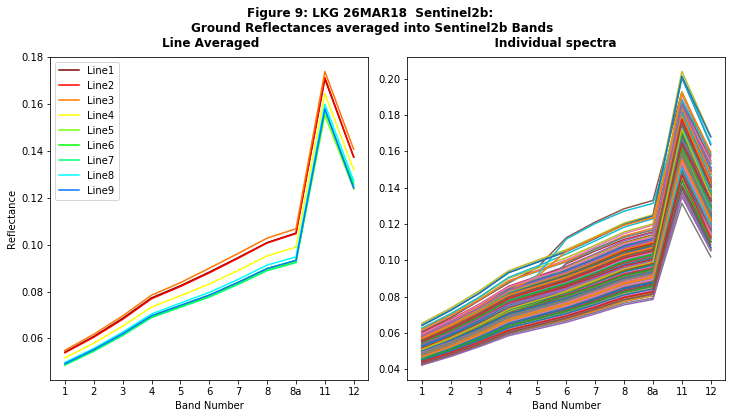

In [24]:
FIG_BandReflectances.FIG_band_reflectances(ground_bands_ls8, result_ls8_df, band_ls8, colpac, output, field_data, fignum)
fignum += 1
FIG_BandReflectances.FIG_band_reflectances(ground_bands_s2a, result_s2a_df, band_s2a, colpac, output, field_data, fignum)
fignum += 1

# Figure

### Histogram of all good spectra, plotted band-by-band

This can be used to identify outlying ground spectra that can be added to bad_grounds in the second cell.

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

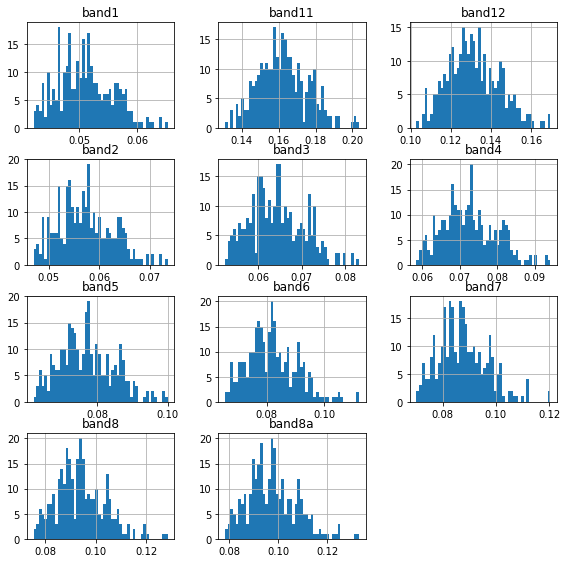

In [25]:
FIG_SpecHistogram.FIG_spec_histogram(ground_bands_s2b, output, field_data, fignum)
fignum += 1

### Outlying ground spectra

Display the spectra with maximum and minimum values. These can be compared to the histograms above<BR>
    to identify any outlying spectra that need to be identified as bad ground spectra.

In [26]:
maxfile = ground_bands_s2b['filename'][(ground_bands_s2b['band1'] == ground_bands_s2b['band1'].max())]
maxbands = ground_bands_s2b.filter(like='band')[(ground_bands_s2b['band1'] == ground_bands_s2b['band1'].max())]
minfile = ground_bands_s2b['filename'][(ground_bands_s2b['band1'] == ground_bands_s2b['band1'].min())]
minbands = ground_bands_s2b.filter(like='band')[(ground_bands_s2b['band1'] == ground_bands_s2b['band1'].min())]

print("Maximum value found in:", maxfile.iloc[0], '\n', maxbands.iloc[0], '\nMinimum value found in:', minfile.iloc[0], '\n', minbands.iloc[0])
#print(ground_bands['filename'][(ground_bands['band1'] == ground_bands['band1'].max())], '\n',ground_bands.filter(like='band')[(ground_bands['band1'] == ground_bands['band1'].max())])
#print(ground_bands['filename'][(ground_bands['band1'] == ground_bands['band1'].min())], '\n',ground_bands.filter(like='band')[(ground_bands['band1'] == ground_bands['band1'].min())])


Maximum value found in: llg_l300008.asd.rad 
 band1     0.065165
band2     0.073572
band3     0.083111
band4     0.094167
band5     0.099964
band6     0.105557
band7     0.112391
band8     0.120428
band8a    0.124889
band11    0.203511
band12    0.169634
Name: 68, dtype: float64 
Minimum value found in: lkg_l900034.asd.rad 
 band1     0.042168
band2     0.046964
band3     0.052372
band4     0.058414
band5     0.062106
band6     0.065666
band7     0.070099
band8     0.075430
band8a    0.078331
band11    0.134838
band12    0.107209
Name: 294, dtype: float64


### Determine Solar angle

Based on the spectrum Latitude, Longitude and time stamp, calculate the angle of<BR>
the Sun, with respect to the zenith. Append this number to the "ground_bands" dataframe.

In [27]:
def solar_angle(row):

    loc = coord.EarthLocation(lon=row['Longitude'] * u.deg,
                              lat=row['Latitude'] * u.deg)
    #timy0 = timei.to_pydatetime()
    timy = Time(row['date_saved'], format='datetime')
    
    altaz = coord.AltAz(location=loc, obstime=timy)
    sun = coord.get_sun(timy)

    return sun.transform_to(altaz).zen.degree

ground_bands_ls8['Solar_angle'] = ground_bands_ls8.apply(solar_angle, axis=1)
ground_bands_s2a['Solar_angle'] = ground_bands_s2a.apply(solar_angle, axis=1)
ground_bands_s2b['Solar_angle'] = ground_bands_s2b.apply(solar_angle, axis=1)

### BRDF Calculation

The following script is adapted from FORTRAN code that will calculate the adjusted ASD measurement to 45$^\circ$. This is derived from "MODIS BRDF / Albedo Product: Algorithm Theoretical basis Docuement Version 5.0" by Strahler et al. (1999).

What follows is a key to the variables used in this code, compared to the variables and equations in the document:

hb and br = h/b and b/r . . . . . . . . . . . . . . . crown shape parameters, respectively.<BR>
RL_brdf = R($\theta, \vartheta, \phi, \Lambda$). . . . . . . . . . . . . . (37)<BR>
solar = $\theta$ . . . . . . . . . . . . . . . . . . . . . . . . . . solar zenith angle<BR>
view = $\xi$ . . . . . . . . . . . . . . . . . . . . . . . . . . .view zenith angle<BR>
ra = $\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . view-sun relative azimuth angle<BR>
cosxi = cos $\xi^\prime$ . . . . . . . . . . . . . . . . . . . . . . (43)<BR>
rs_thick = K$_{vol}$ = RossThick kernel . . . . . . (38)<BR>
d_li2 = D$^2$ . . . . . . . . . . . . . . . . . . . . . . . . . (42)<BR>
x_li = tan$\theta^\prime$ tan$\vartheta^\prime$ sin$\phi$ . . . . . . . . . . . . . . .(41) (part of)<BR>
cosl = cos $t$ . . . . . . . . . . . . . . . . . . . . . . . . (41)<BR>
l_li = $t$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . .constrained such that $-1 \leq t \leq 1$<BR>
o_li = O($\theta, \vartheta, \phi$) . . . . . . . . . . . . . . . . . . . .(40)<BR>
li_sparse = K$_{geo}$ . . . . . . . . . . . . . . . . . . . . (39)<BR><BR><BR>

Equations used for the Ross-Li BRDF model:

R($\theta, \vartheta, \phi, \Lambda$) = $f_{iso}(\Lambda) + f_{vol}(\Lambda)\,K_{vol}(\theta, \vartheta, \phi) + f_{geo}(\Lambda)\,K_{geo}(\theta, \vartheta, \phi)$ . . . . . . . . (37)

$K_{vol} = k_{RT} = \frac{(\pi/2 - \xi)\rm{cos}\,\xi + \rm{sin}\,\xi}{\rm{cos}\,\theta + \rm{cos}\,\vartheta} - \frac{\pi}{4}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (38)
    
$K_{geo} = k_{LSR} = O(\theta, \vartheta, \phi) - {\rm sec}\,\theta^\prime - {\rm sec}\,\vartheta^\prime + \frac{1}{2} (1 + \rm{cos}\,\xi^\prime)\, \rm{sec}\,\theta^\prime \rm{sec}\,\vartheta^\prime$ . . . (39)

$O = \frac{1}{\pi}(t - \rm{sin}\,t\,\,\rm{cos}\,t)(\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (40)

$\rm{cos}\,t = \frac{h}{b}\frac{\sqrt{D^2 + (\rm{tan}\,\theta^\prime\,\,\rm{tan}\,\vartheta^\prime\,\,\rm{sin}\,\phi)^2}}{\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (41)

$D = \sqrt{\rm{tan}^2\,\theta^\prime + \rm{tan}^2\,\vartheta^\prime - 2\,\rm{tan}\,\theta^\prime\,\rm{tan}\,\vartheta^\prime\,\rm{cos}\,\phi}$ . . . . . . . . . . . . . . . . . . . . . . . . . . (42)

$\rm{cos}\,\xi^\prime = \rm{cos}\,\theta^\prime\,\rm{cos}\,\vartheta^\prime + \rm{sin}\,\theta^\prime\,\rm{sin}\,\vartheta^\prime\,\rm{cos}\,\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(43)

$\theta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\theta)\,\vartheta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\vartheta)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(44)

In [28]:
ground_brdf_ls8, hb, br = BRDF.ReadAndCalc(brdf_data, ground_bands_ls8, ['','','','Landsat8'])
ground_brdf_s2a, hb, br = BRDF.ReadAndCalc(brdf_data, ground_bands_s2a, ['','','','Sentinel2a'])
ground_brdf_s2b, hb, br = BRDF.ReadAndCalc(brdf_data, ground_bands_s2b, ['','','','Sentinel2b'])

### Choose bands for Landsat 8 and Sentinel satellite data

In [29]:
from CalVal.ApplyWeights import get_spectrum_curve

band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',11,12]
ls8_bands = [1,2,3,4,5,6,7]

if field_data[3] == 'Landsat8':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', field_data[3])

# Figure 

### Plot satellite band extents against median ground spectrum

This plot will show where the satellite bands fall, with respect to the spectrum<BR>
and in particular, with respect to the atmospheric absorbtion features.

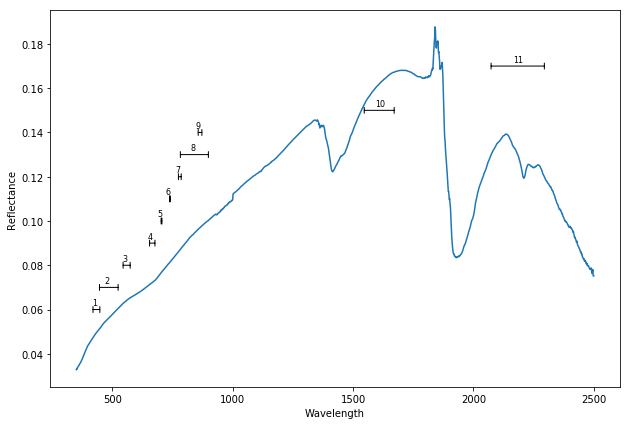

In [30]:
FIG_BandExtents.FIG_band_extents(all_refls, band_min, band_max, output, field_data, fignum)
fignum += 1

### Fudge GPS locations if none exist

In [31]:
ground_brdf_ls8 = FudgeGPS.fudge_gps(ground_brdf_ls8, Corners, RockWalk, StartCorner)
ground_brdf_s2a = FudgeGPS.fudge_gps(ground_brdf_s2a, Corners, RockWalk, StartCorner)
ground_brdf_s2b = FudgeGPS.fudge_gps(ground_brdf_s2b, Corners, RockWalk, StartCorner)

Assuming good GPS Coordinates, continuing...
Assuming good GPS Coordinates, continuing...
Assuming good GPS Coordinates, continuing...


### Query Satellite data

Retrieve xarrays for satellite data, based on which satellite, query area and time.<BR>
sat_array will contain all band data<BR>
sat_bigarray will be a larger version of sat_array, which can be used for context plotting.

In [32]:
ldc, sdc, lquery, squery, lquery2, squery2 = LongQuery.make_long_query(ground_brdf_ls8)

ls8_array, s2a_array, s2b_array, ls8_bigarray, s2a_bigarray, s2b_bigarray = CreateLongArrays.create_long_arrays_nomask(ldc, sdc, lquery, squery, lquery2, squery2)

# Figure 

### Plot relative locations of field and satellite data

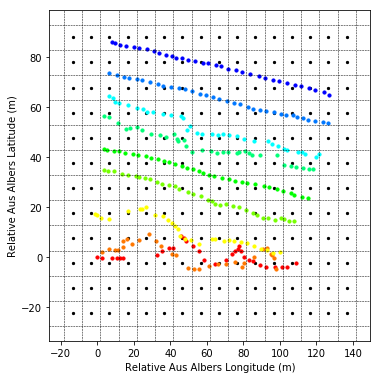

In [33]:
xloc = FIG_SatFieldLocations.FIG_sat_field_locations(ground_brdf_ls8, s2a_array, colpac, output, field_data, fignum)
fignum +=1

### Create Field full band xarray

The field xarray is based on the pixel locations of the satellite data, where each pixel<BR>
    contains an average of all field data measurements that fall within the pixel.

In [34]:
field_array_ls8, field_array_s2a = CreateManyFieldFromSat.create_many_field_from_sat(ls8_array, s2a_array, ground_brdf_ls8, ground_brdf_s2a, xloc)

# Figure 

### Plot large-area context RGB array for Satellite data

Landsat 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

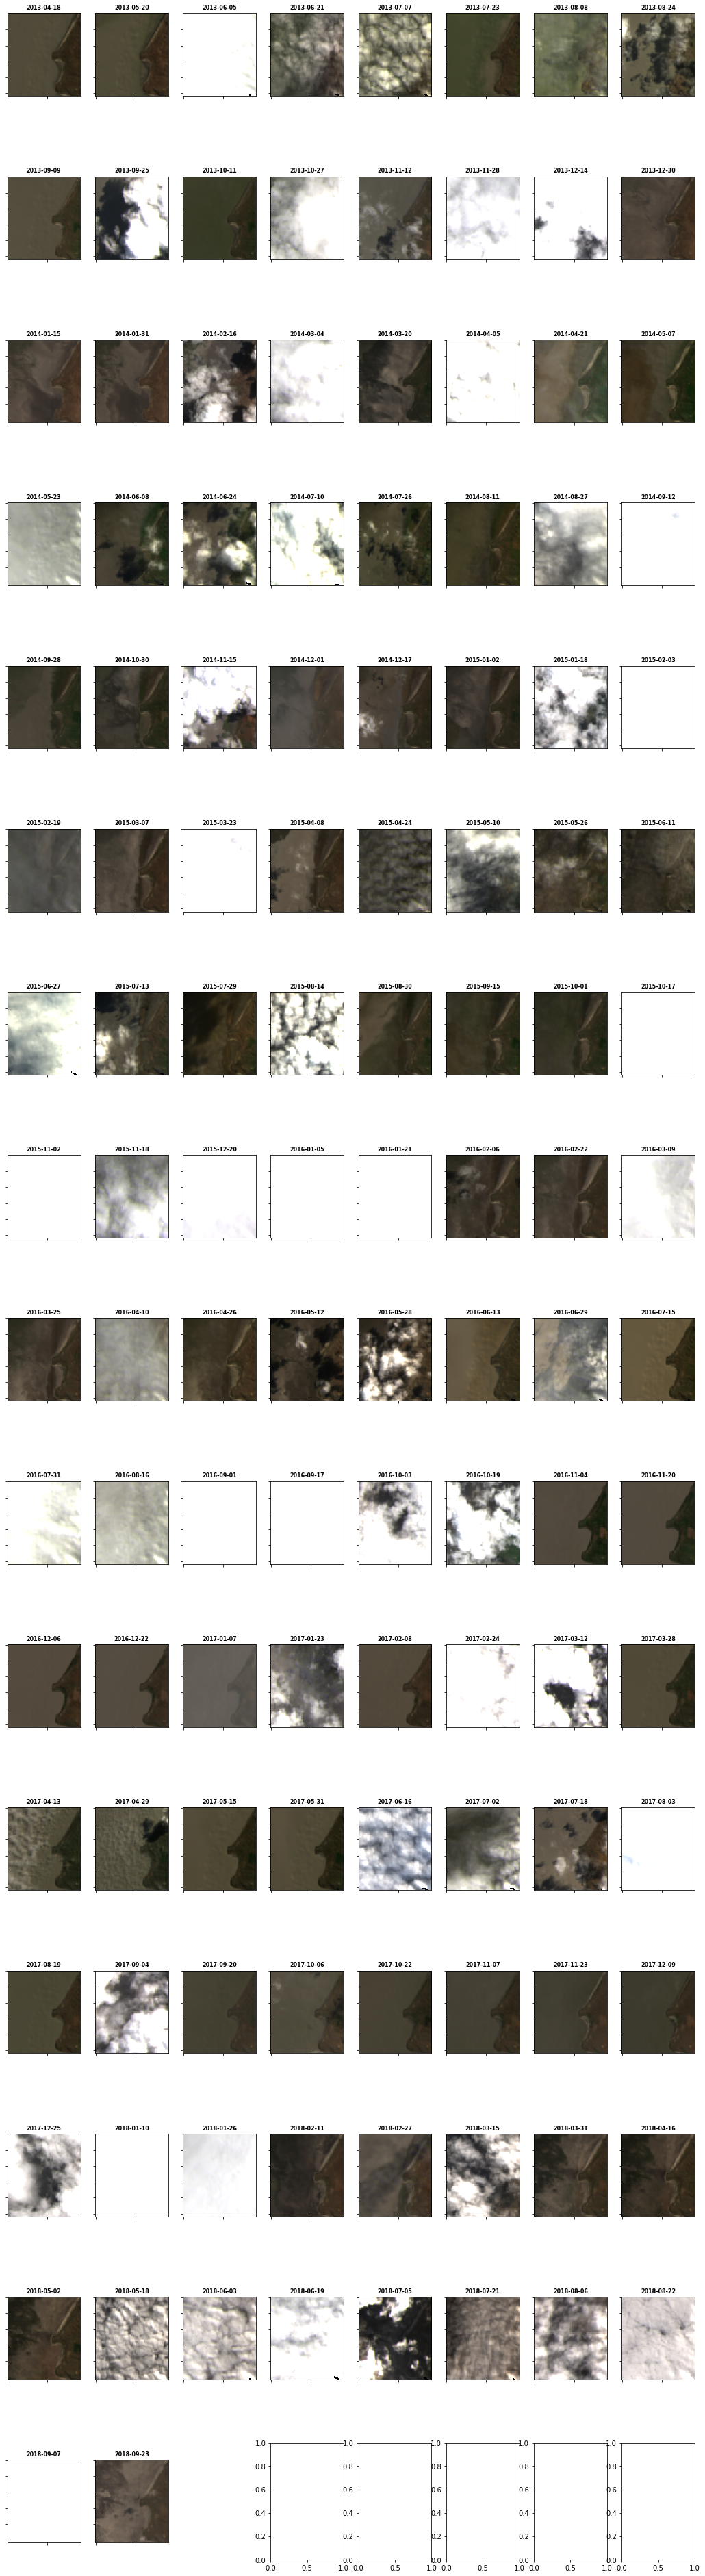

In [35]:
FIG_ManyLS8RGB.FIG_many_LS8RGB(ls8_bigarray, output, field_data, fignum)
fignum += 1

Sentinel 2a


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

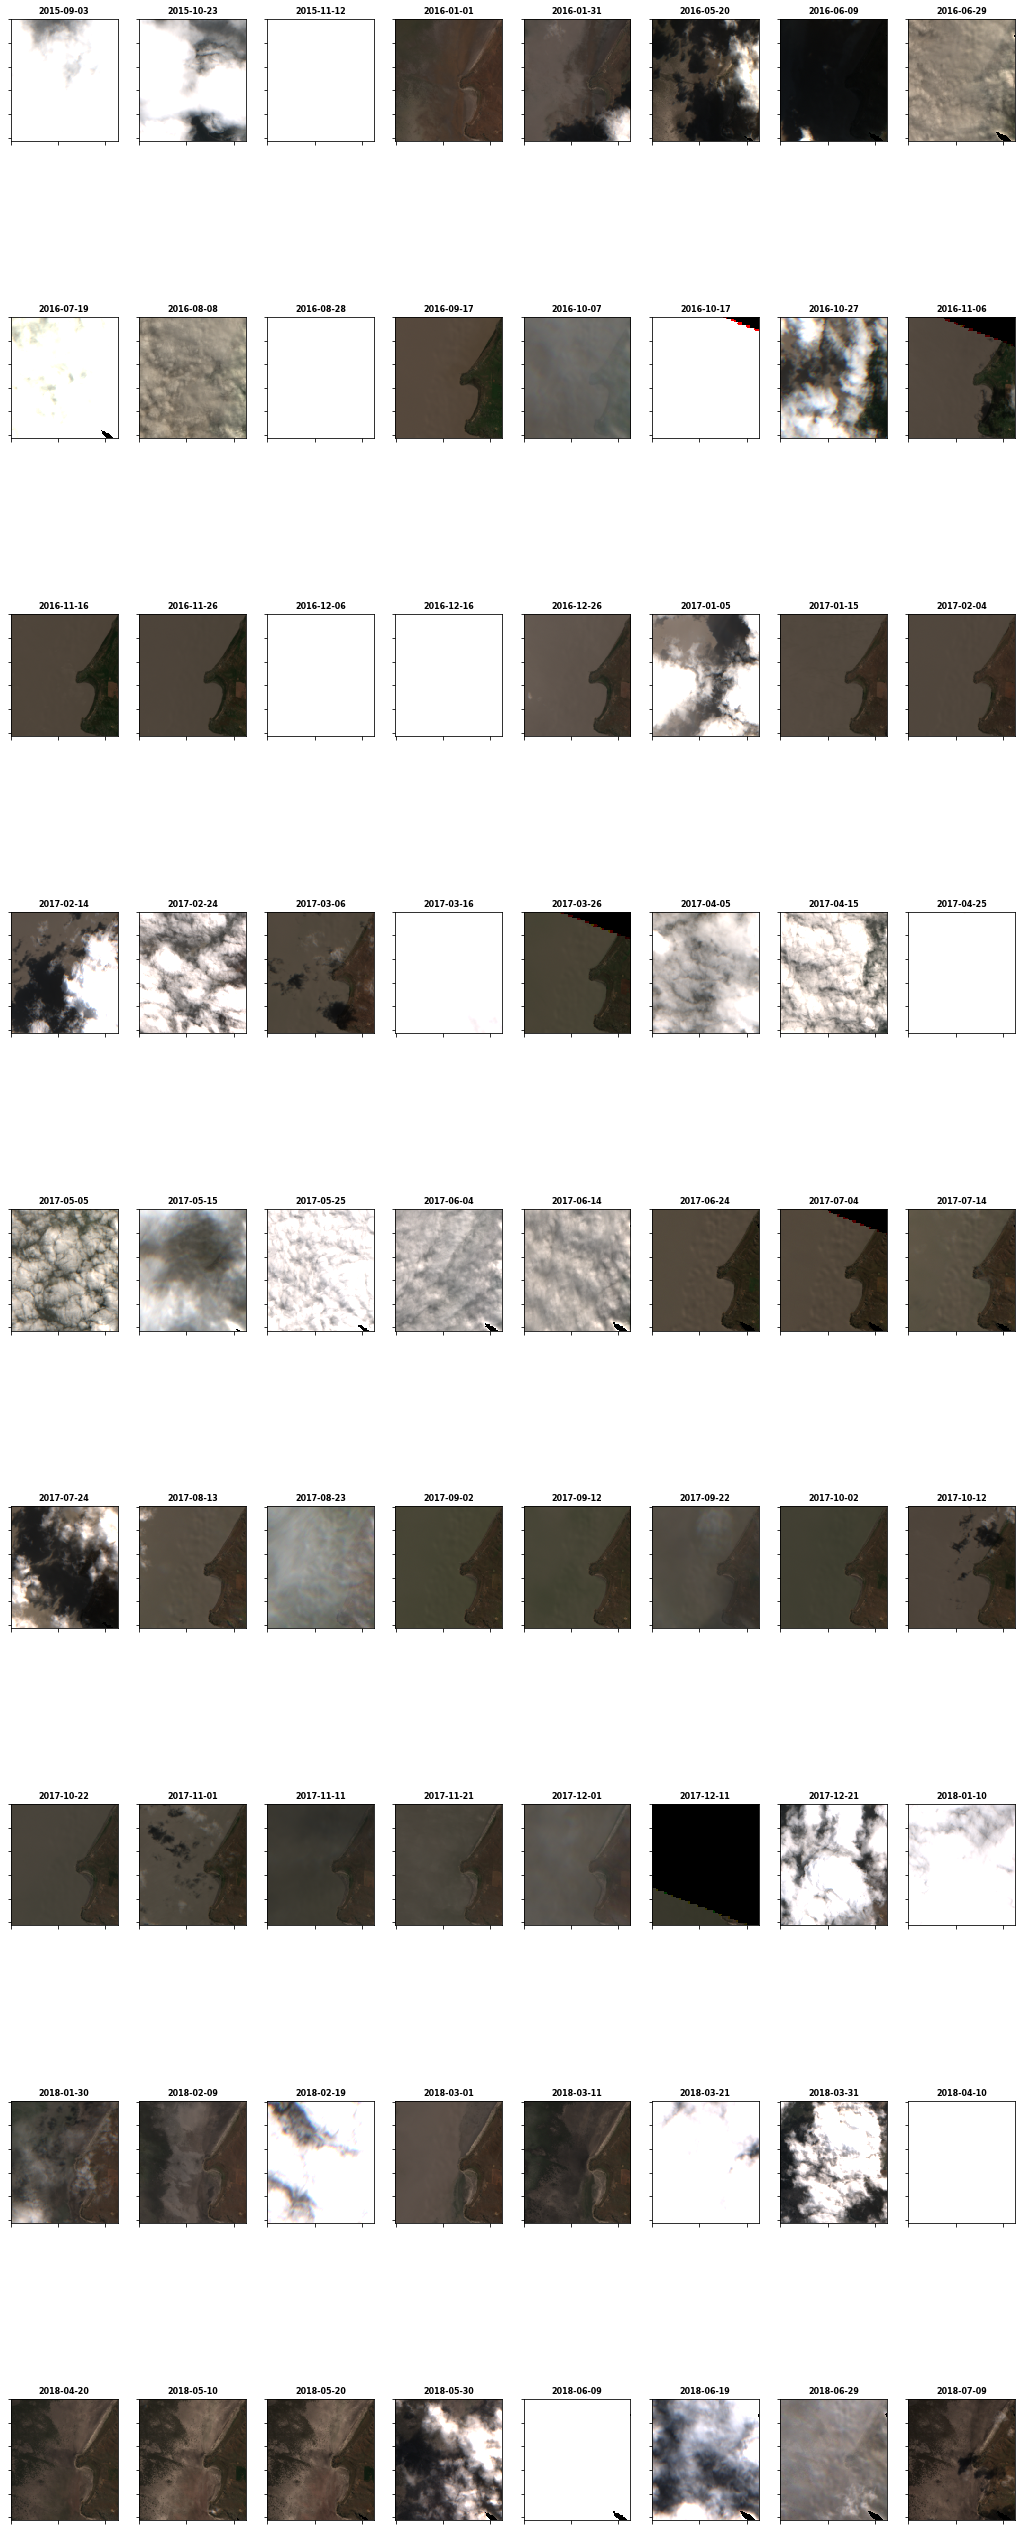

In [36]:
FIG_ManyS2ARGB.FIG_many_S2ARGB(s2a_bigarray, output, field_data, fignum)
fignum += 1

Sentinel 2b


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

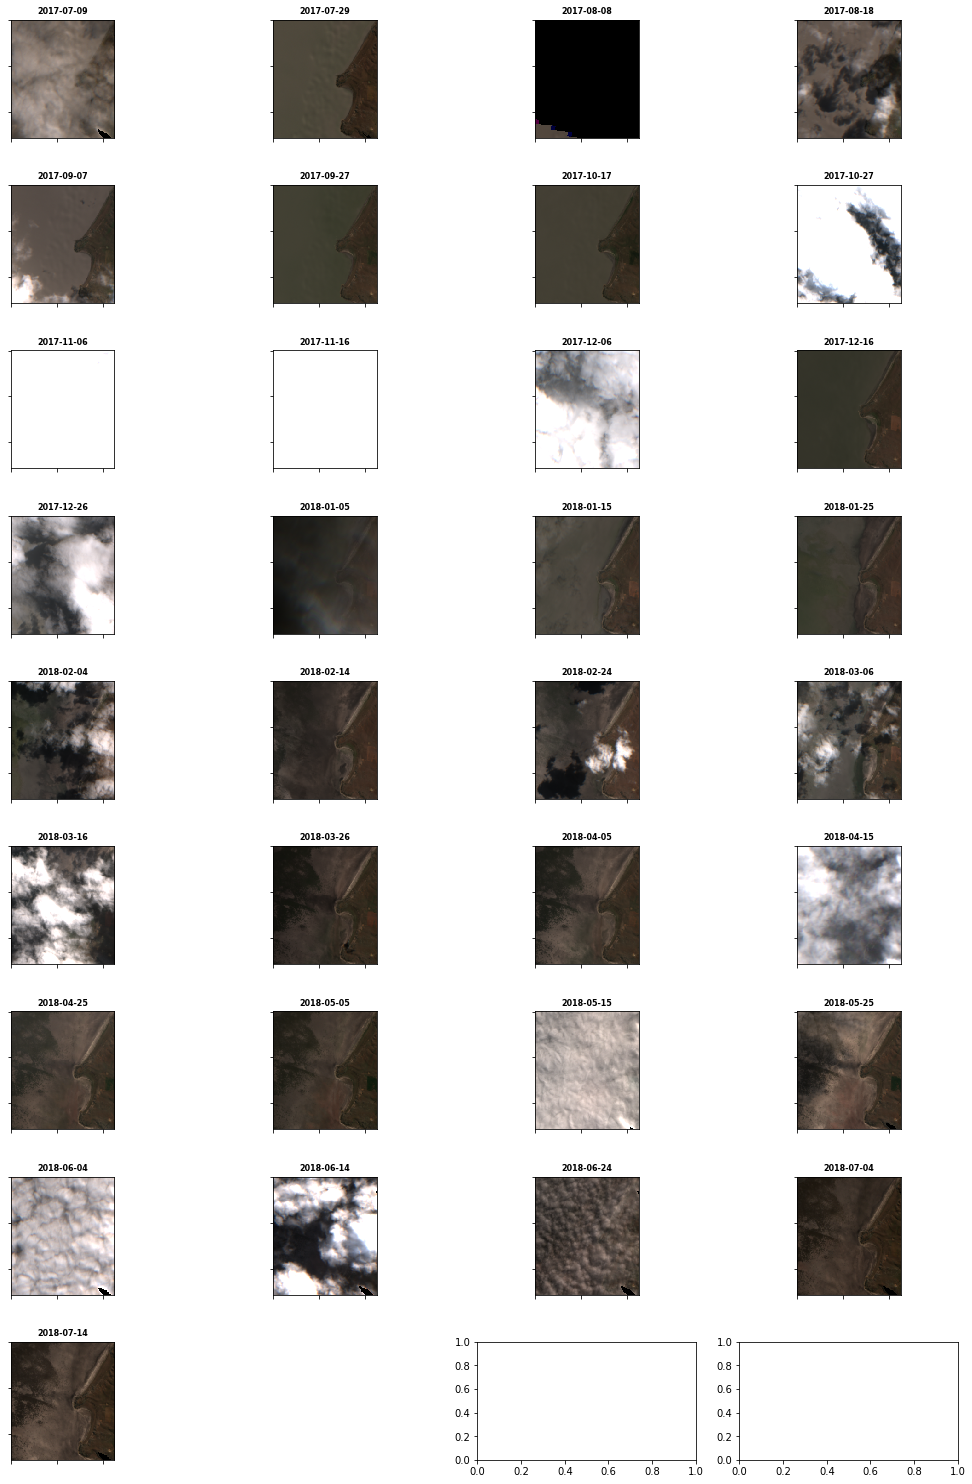

In [37]:
FIG_ManyS2BRGB.FIG_many_S2BRGB(s2b_bigarray, output, field_data, fignum)
fignum += 1

# Figure 

### Plot RGB array for Field data

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


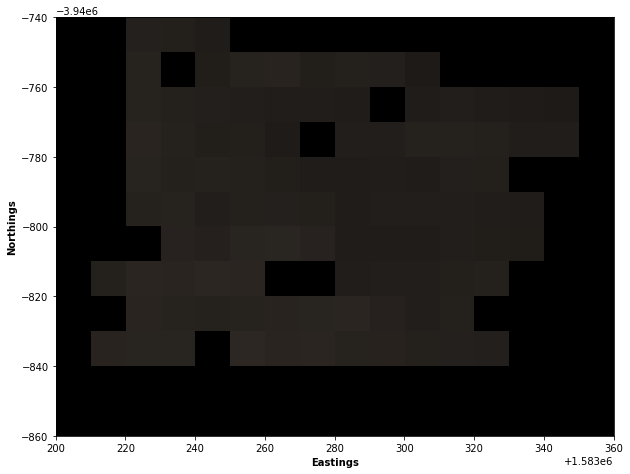

In [40]:
FIG_FieldRGB.FIG_field_RGB(field_array_s2a, output, field_data, fignum)
fignum += 1

### Create a statistics dataframe, comparing satellite and field data

In [41]:
fls8_df, fs2a_df, fs2b_df = CreateManyStats.create_manystats(ls8_array, s2a_array, s2b_array, ls8_bad_days, s2a_bad_days, s2b_bad_days, ground_brdf_ls8, ground_brdf_s2a, field_data)

# Figure

### Plot comparison spectra of satellite and field data, on a pixel-by-pixel basis

Error bars are shown for the satellite and field data, based on the standard deviation of the pixels
within the field. The black line shows the satellite data, which has been averaged over all pixels that satisfy the Datacube query ie. all pixels shown in Figure 11. The orange line shows satellite data which has been averaged over only those pixels that overlap with at least one field measurement.

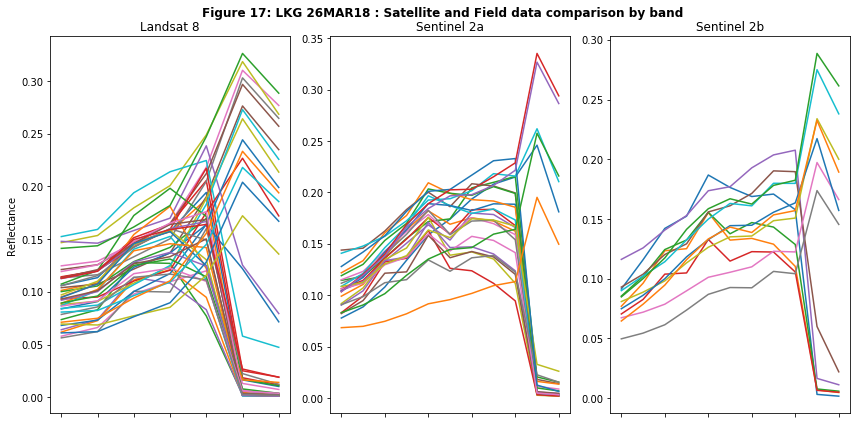

In [42]:
FIG_ManySatFieldBands.FIG_many_sat_field_bands(ls8_array, s2a_array, s2b_array, fls8_df, fs2a_df, fs2b_df, output, field_data, fignum)
fignum += 1

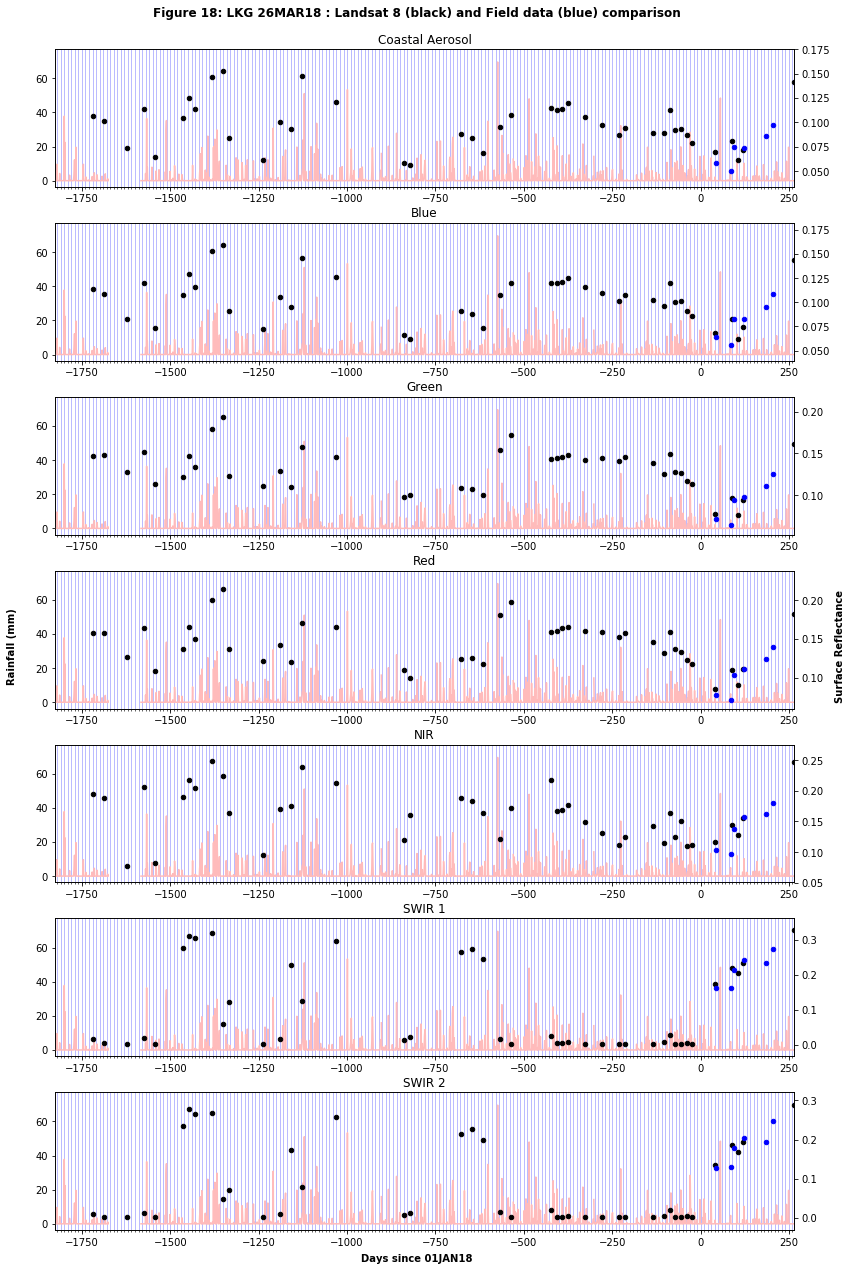

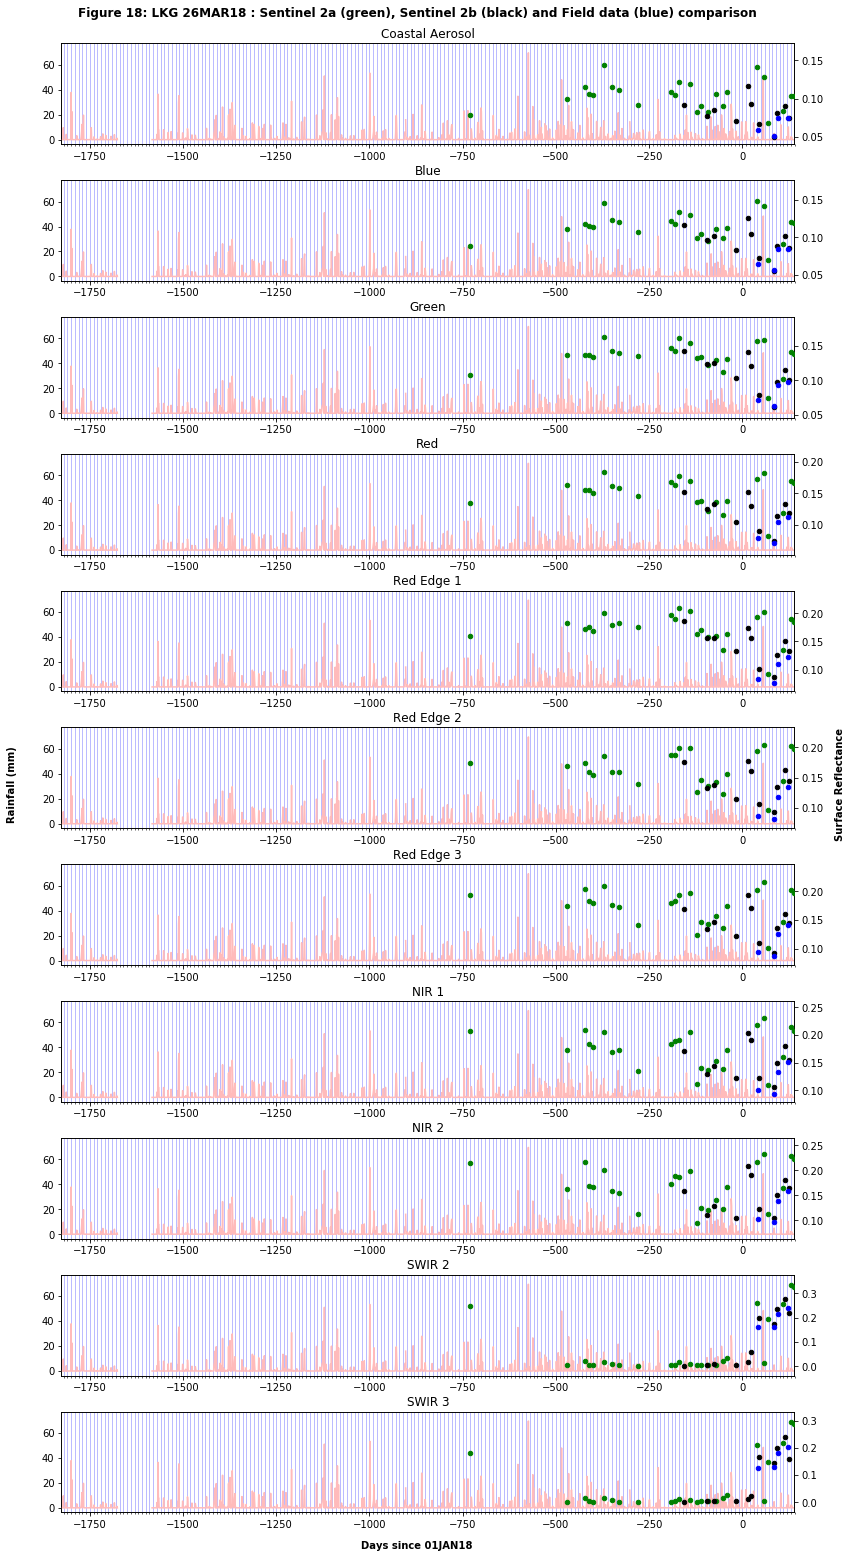

In [43]:
FIG_MultiTimeLine.FIG_multi_time_line(fls8_df, fs2a_df, fs2b_df, ls8_csvs, sent_csvs, rain_dat, field_data, output, fignum)
fignum+=1

In [44]:
dd0_ls8, dd1_ls8, dd0_s2a, dd1_s2a, dd0_s2b, dd1_s2b = CalcStats.calc_stats(fls8_df, fs2a_df, fs2b_df)

LANDSAT 8: Number of adjacent overpasses: 43
Landsat 8 Surface Reflectance for Band 1 is 0.099+/-0.022 (22.05%)
Landsat 8 Surface Reflectance for Band 2 is 0.105+/-0.022 (20.79%)
Landsat 8 Surface Reflectance for Band 3 is 0.13+/-0.023 (17.74%)
Landsat 8 Surface Reflectance for Band 4 is 0.143+/-0.025 (17.64%)
Landsat 8 Surface Reflectance for Band 5 is 0.157+/-0.034 (21.8%)
Landsat 8 Surface Reflectance for Band 6 is 0.077+/-0.023 (29.42%)
Landsat 8 Surface Reflectance for Band 7 is 0.065+/-0.017 (26.77%)

SENTINEL 2a: Number of adjacent overpasses: 25
Sentinel 2a Surface Reflectance for Band 1 is 0.105+/-0.024 (23.28%)
Sentinel 2a Surface Reflectance for Band 2 is 0.116+/-0.028 (23.99%)
Sentinel 2a Surface Reflectance for Band 3 is 0.138+/-0.032 (23.35%)
Sentinel 2a Surface Reflectance for Band 4 is 0.155+/-0.038 (24.39%)
Sentinel 2a Surface Reflectance for Band 5 is 0.178+/-0.043 (24.15%)
Sentinel 2a Surface Reflectance for Band 6 is 0.17+/-0.043 (25.09%)
Sentinel 2a Surface Reflect

In [45]:
MultiTimeLineDry.multi_time_line_dry(fls8_df, fs2a_df, fs2b_df, ls8_csvs, sent_csvs, rain_dat, field_data, output, fignum)

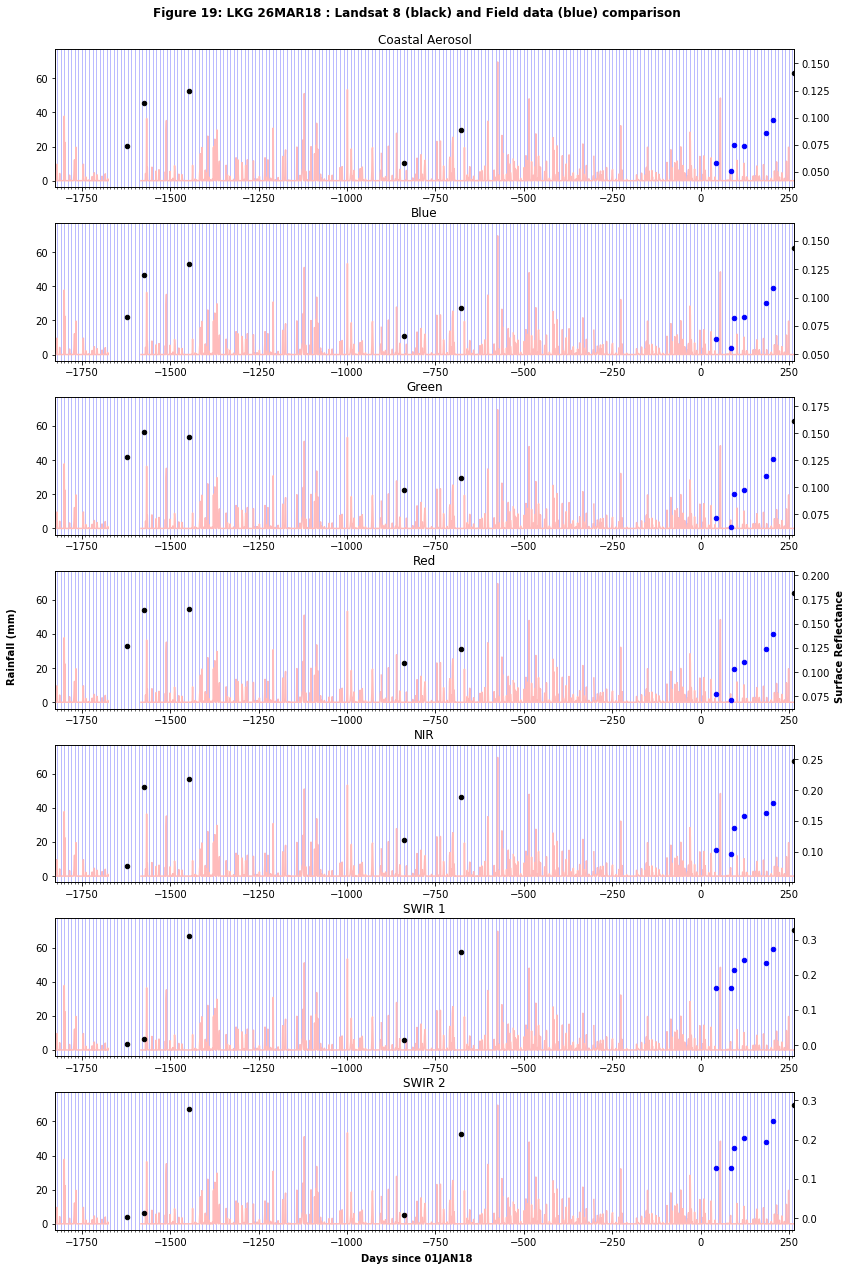

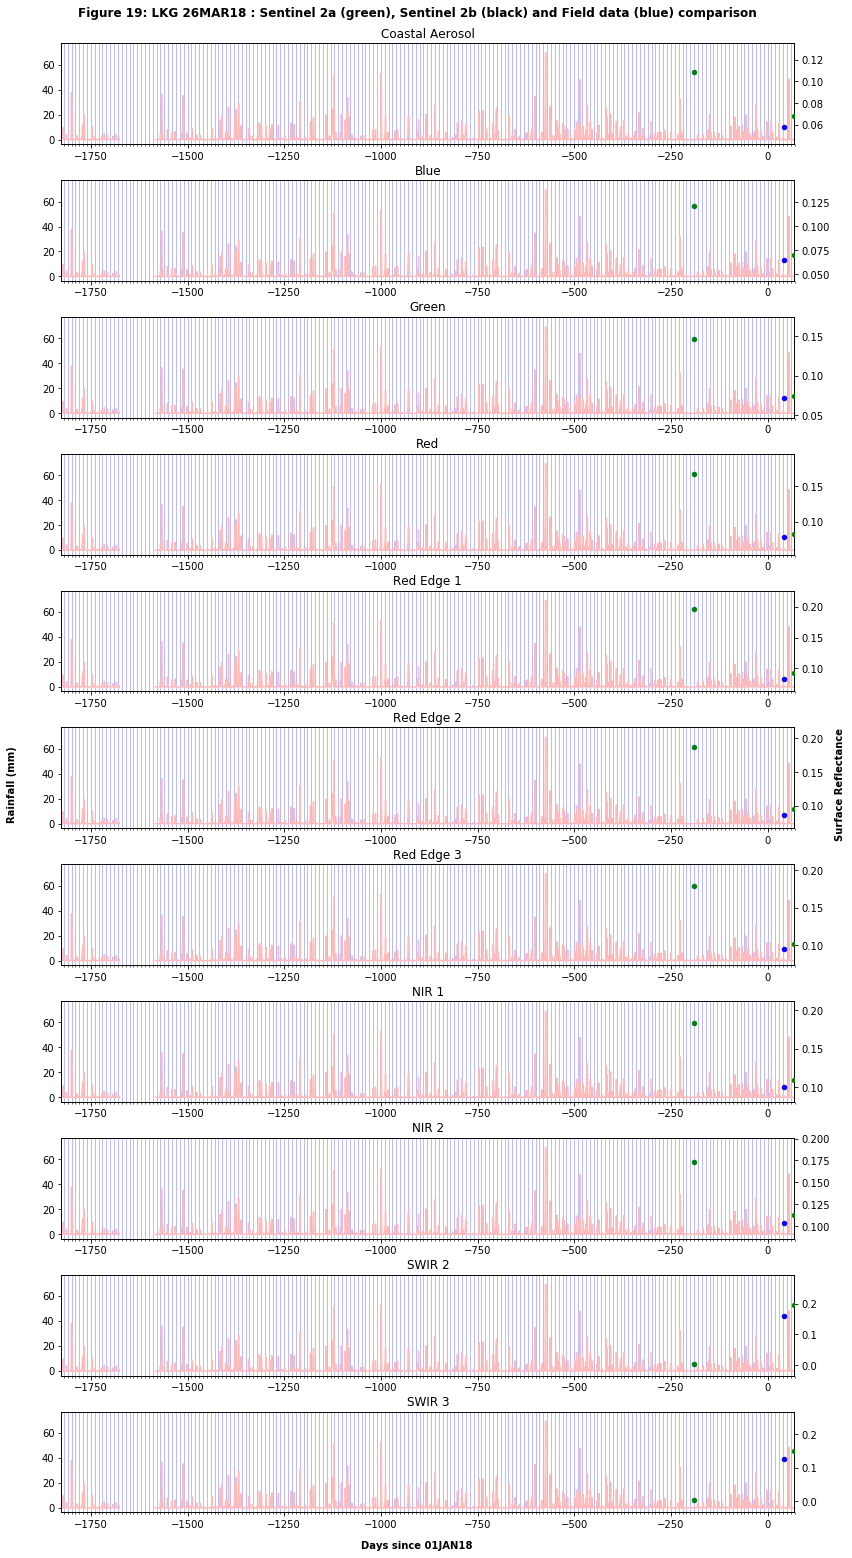

In [46]:
FIG_MultiTimeLine.FIG_multi_time_line(fls8_df, fs2a_df, fs2b_df, ls8_csvs, sent_csvs, rain_dat, field_data, output, fignum)
fignum+=1

In [47]:
dd0_ls8, dd1_ls8, dd0_s2a, dd1_s2a, dd0_s2b, dd1_s2b = CalcStats.calc_stats(fls8_df, fs2a_df, fs2b_df)

ValueError: No objects to concatenate

## How long did this notebook take to run?